In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import PIL
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#mport os
#or dirname, _, filenames in os.walk('/kaggle/input'):
#   for filename in filenames:
#       print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import warnings

warnings.filterwarnings(action='ignore')

In [3]:
from glob import glob

all_faces = glob('../input/biggest-genderface-recognition-dataset/faces/*/*')

In [4]:
img_count = len(list(all_faces))
print(img_count)

27167


In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
'../input/biggest-genderface-recognition-dataset/faces',
validation_split = .25,
subset = 'training',
seed = 123,
image_size = (img_height, img_width),
batch_size = batch_size)

Found 27167 files belonging to 2 classes.
Using 20376 files for training.


2022-04-14 14:09:58.780892: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 14:09:58.894907: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 14:09:58.895979: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 14:09:58.899116: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
   '../input/biggest-genderface-recognition-dataset/faces',
  validation_split=0.25,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27167 files belonging to 2 classes.
Using 6791 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['man', 'woman']


2022-04-14 14:10:07.943248: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


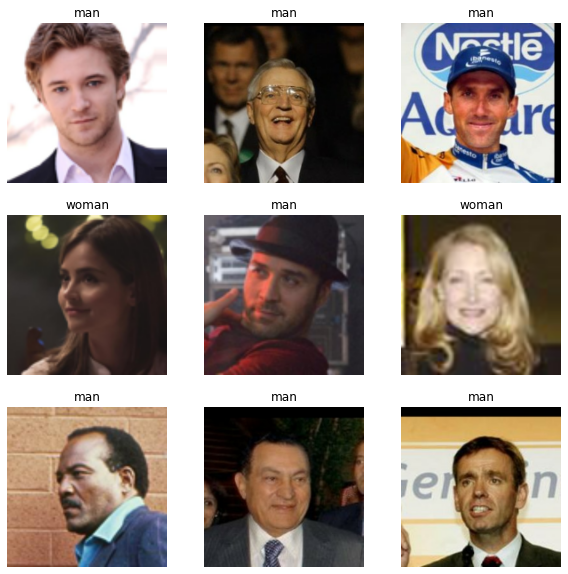

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [11]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255.)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

2022-04-14 14:10:19.835096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 128 of 1000
2022-04-14 14:10:29.811475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 262 of 1000
2022-04-14 14:10:39.784049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 393 of 1000
2022-04-14 14:10:49.812773: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 522 of 1000


0.0 1.0


2022-04-14 14:10:57.907825: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


In [13]:
num_classes = 2

In [14]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal',
                                                input_shape = (img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
])

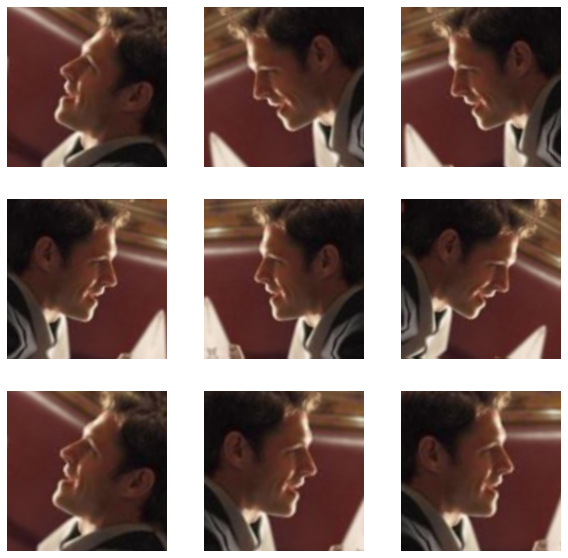

In [15]:
plt.figure(figsize = (10, 10))

for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

In [16]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
    
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)       

In [18]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
)

Epoch 1/15


2022-04-14 14:11:01.915959: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


637/637 [==============================] - 35s 43ms/step - loss: 0.4913 - acc: 0.7573 - val_loss: 0.3841 - val_acc: 0.8233
Epoch 2/15
637/637 [==============================] - 11s 17ms/step - loss: 0.3922 - acc: 0.8225 - val_loss: 0.3229 - val_acc: 0.8539
Epoch 3/15
637/637 [==============================] - 11s 17ms/step - loss: 0.3413 - acc: 0.8530 - val_loss: 0.2836 - val_acc: 0.8810
Epoch 4/15
637/637 [==============================] - 11s 17ms/step - loss: 0.3135 - acc: 0.8652 - val_loss: 0.2708 - val_acc: 0.8832
Epoch 5/15
637/637 [==============================] - 11s 17ms/step - loss: 0.2944 - acc: 0.8740 - val_loss: 0.2666 - val_acc: 0.8968
Epoch 6/15
637/637 [==============================] - 11s 17ms/step - loss: 0.2782 - acc: 0.8830 - val_loss: 0.2561 - val_acc: 0.8950
Epoch 7/15
637/637 [==============================] - 11s 17ms/step - loss: 0.2673 - acc: 0.8869 - val_loss: 0.2526 - val_acc: 0.8982
Epoch 8/15
637/637 [==============================] - 11s 17ms/step - los

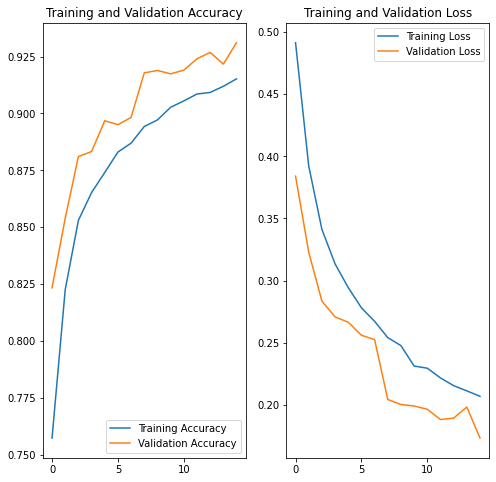

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = 15
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('figure_1.png')
plt.show()

In [20]:
score = sum(val_acc) / len(val_acc)

print(score)

0.9005448381106059
